In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax
import brax

import matplotlib.pyplot as plt

In [4]:
from models.base_model import BaseModel, NormalDistPredictor

# from agents.REINFORCE_continuous import ActorCriticContinuous
from agents.PPO_v2 import PPOContinuous
from agents.advantage_estimator import gae_estimator

from trainer_v2 import build_trainer

from utils.callbacks import versatile_callback_v2

In [5]:
actor_lr = 1e-4
critic_lr = 1e-4

discount = 0.99

clip_ratio = 0.2
ppo_steps = 4

num_envs = 512

update_iters = 50000

train_rollout_steps = 20
eval_rollout_steps = 1000
eval_every = 400

env_name = "hopper"
backend = "positional"

In [6]:
# https://github.com/luchris429/purejaxrl/blob/5343613b07b3bc543c49695df601fc40f5ec3062/purejaxrl/wrappers.py#L117

from gymnax.environments import environment, spaces
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper

class BraxGymnaxWrapper:
    def __init__(self, env_name, backend="positional"):
        env = envs.get_environment(env_name=env_name, backend=backend)
        env = EpisodeWrapper(env, episode_length=1000, action_repeat=1)
        env = AutoResetWrapper(env)
        self._env = env
        self.action_size = env.action_size
        self.observation_size = (env.observation_size,)

    def reset(self, key, params=None):
        state = self._env.reset(key)
        return state.obs, state

    def step(self, key, state, action, params=None):
        next_state = self._env.step(state, action)
        return next_state.obs, next_state, next_state.reward, next_state.done > 0.5, {}

    def observation_space(self, params):
        return spaces.Box(
            low=-jnp.inf,
            high=jnp.inf,
            shape=(self._env.observation_size,),
        )

    def action_space(self, params):
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self._env.action_size,),
        )

In [7]:
from brax import envs

env, env_params = BraxGymnaxWrapper(env_name), None

obs_size = env.observation_space(env_params).shape
action_size = env.action_space(env_params).shape[0]

In [8]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

steps = ppo_steps * update_iters
# lr_scheduler = optax.linear_schedule(
#   init_value=5e-4,
#   end_value=5e-4,
#   transition_steps=steps,
# )

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(64)
    
    dummy = jnp.ones([1, *obs_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), NormalDistPredictor(output_size = action_size, logvar_init_value = 0, limits = (-1, 1))])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    # actor_tx = optax.adam(lr_scheduler)
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), nn.Dense(features = 1)])
    critic_params = critic_model.init(critic_init_key, dummy)['params']
    # critic_tx = optax.adam(lr_scheduler)
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = PPOContinuous(gae_estimator(discount, 0.95),
                          clip_ratio, ppo_steps)
    
    callback = versatile_callback_v2(update_iters, tqdm_keys = ["episode_reward"], split_train_eval = True)

    train = build_trainer(agent, env, env_params, num_envs, obs_size, action_size, 
                            train_rollout_steps, eval_rollout_steps, eval_every, 
                            callback, 
                            )
    
    actor, critic = train(update_iters, actor, critic, key)

 18%|█▊        | 9121/50000 [07:38<25:40, 26.53it/s, episode_reward=1450.952]   IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 50000/50000 [35:27<00:00, 27.01it/s, episode_reward=1751.5522]

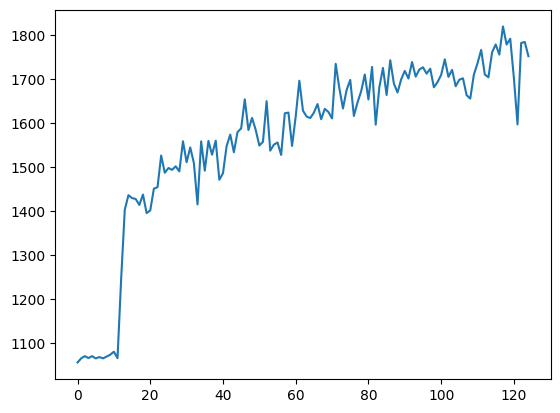

In [9]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(callback.eval_history["episode_reward"])
plt.show()

In [11]:
from IPython.display import HTML

from brax.io import html
from tqdm.notebook import tqdm

# actor = carry[0]

env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(lambda obs: agent.suggest_action(obs, actor))

total_rewards = 0

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in tqdm(range(1000)):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act = jit_inference_fn(state.obs)
    state = jit_env_step(state, act)

    if state.done:
        print("Done at", _)

    # print(state.done, state.reward)

    total_rewards += state.reward

print(total_rewards)

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

  0%|          | 0/1000 [00:00<?, ?it/s]

Done at 999
1748.0267
